### Prepare landcover input for discretization ###
Prepare landcover input data for the domain area. This step includes:<br>
1. project large-domain input into a common projection system.
3. resample input according to a reference raster (if needed).
2. extract input for the basin area.
4. classifiy landcover into canopy and non-canopy.
5. check basin landcover and landcover class.

In [1]:
# import libraries
import os, sys 
sys.path.append('../')
import functions.geospatial_analysis as ga
import functions.geospatial_plot as gp
import functions.utils as ut
import rasterio as rio
import rasterio.shutil
from rasterio.warp import Resampling

#### Set data files, paths and other entries ####

In [2]:
# common paths
control_file    = '../control_Utah.txt'
basin_data_path   = ut.read_from_control(control_file, 'basin_data_path')
basin_name        = ut.read_from_control(control_file, 'basin_name')
plot_path         = os.path.join(basin_data_path, 'plots')  # this is made in 'prepare_basin_shapefiles' script
gis_path          = os.path.join(basin_data_path, 'gis')

In [3]:
# define equal area projection system
new_epsg = ut.read_from_control(control_file, 'epsg') 
dest_crs = rio.crs.CRS.from_epsg(new_epsg)

In [4]:
dest_crs

CRS.from_epsg(6933)

In [5]:
# large-domain data
landcover_raster                = ut.read_from_control(control_file, 'fulldom_landcover_raster')

# basin data
basin_gru_shp                   = ut.set_filename(control_file, 'basin_gru_shp')
basin_flowlines_shp             = ut.read_from_control(control_file, 'basin_flowlines_shp')
basin_landcover_resample_raster = ut.set_filename(control_file, 'basin_landcover_resample_raster')
basin_landcover_raster          = ut.set_filename(control_file, 'basin_landcover_raster') 
basin_canopy_class_raster       = ut.set_filename(control_file, 'basin_canopy_class_raster')
refraster                       = ut.set_filename(control_file, 'refraster')

# derived filenames
landcover_prj_raster   = os.path.join(gis_path, os.path.basename(landcover_raster).split('.tif')[0]+'_prj.tif')   # note, this full-dom file exists or must written somewhere writable
# landcover_prj_raster = '/home/h294liu/project_kshook/proj_previous/2020_06_02HRUcomplexity/discretize/source_data/annual_climate_lc_prj.tif'
basin_gru_prj_shp      = os.path.join(gis_path, os.path.basename(basin_gru_shp).split('.shp')[0]+'_prj.shp') 
basin_boundary_prj_shp = os.path.join(gis_path, os.path.basename(basin_gru_prj_shp).split('.shp')[0]+'_boundary.shp')
basin_landcover_resample_crop_raster = basin_landcover_resample_raster.split('.tif')[0]+'_crop.tif'

#### 1. Reproject full-domain landcover ####

In [6]:
if not os.path.exists(landcover_prj_raster):
    ga.reproject_raster(landcover_raster, landcover_prj_raster, dest_crs, Resampling.nearest)
elif os.path.exists(landcover_prj_raster):
    with rio.open(landcover_prj_raster) as raster:       
        if raster.crs != dest_crs: # Get the projection information
            print('Existing projected raster does not match the desired dest_crs')
            ga.reproject_raster(landcover_raster, landcover_prj_raster, dest_crs, Resampling.nearest)
print('reprojected landcover raster:', landcover_prj_raster)

reprojected landcover raster: /Users/hongliliu/Documents/tmp/utah/gis/annual_climate_lc_prj.tif


In [9]:
# double check the reprojection succeeds.
import rasterio as rio
def get_raster_projection(raster_path):
    # Open the raster file using rasterio
    with rio.open(raster_path) as raster:
        # Get the projection information
        raster_crs = raster.crs
    return raster_crs

print(get_raster_projection(landcover_raster))
print(get_raster_projection(landcover_prj_raster))
    

GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
EPSG:6933


#### 2. Resample basin-domain landcover (with a buffer margin) ####
Resampling is applied only when the given raster has a coarser resolution than the reference raster, which is specified by the user (defaulting to the domain DEM). The resampling result will slightly exceed the basin domain to facilitate subsequent subsetting. To achieve this, a buffer is used, with the default buffer being 10 pixels around the reference raster domain.

In [10]:
ga.resample_raster(landcover_prj_raster, refraster, basin_landcover_resample_raster) 
print('resampled landcover raster:', basin_landcover_resample_raster)

resampled landcover raster: /Users/hongliliu/Documents/tmp/utah/gis/lc_resample.tif


#### 3. Subset basin-domain landcover ####

In [11]:
ga.crop_raster(basin_landcover_resample_raster, basin_gru_prj_shp, basin_landcover_raster)
print('basin landcover raster:', basin_landcover_raster)

basin landcover raster: /Users/hongliliu/Documents/tmp/utah/gis/landcover.tif


#### 4. Calssify landcover into canopy vs non-canopy. 
Canopy refers to the layer of vegetation, primarily trees and shrubs, that forms the uppermost layer of a forest or vegetation cover. This layer plays a crucial role in the hydrologic cycle, affecting processes such as interception, transpiration, and evapotranspiration. <br>
Here, the source data is the 20-category IGBP land cover dataset at 1/160 degree resolution (IGBP, 1990). Canopy class includes: 1 Evergreen needleleaf forests, 2 Evergreen broadleaf forests, 3 Deciduous needleleaf forests, 4 Deciduous broadleaf forests, 5 Mixed forests, 6 Closed shrublands, and 7 Open shrublands. 

In [12]:
ga.classify_landcover(basin_landcover_raster, basin_canopy_class_raster)
print('classified landcover raster:', basin_canopy_class_raster)

classified landcover raster: /Users/hongliliu/Documents/tmp/utah/gis/canopy_class.tif


#### 5. Visualize basin landcover classification ####

data_unique: [ 0  1  3  4  5  6  7  8  9 10 12 13 14 16]
data_counts: [   968   5788   2809    240   4341     49    746   8988   1149 168813
  24788   5040  43990     64]
length data_unique: 14
legend_labels: {np.uint8(0): ['royalblue', 'Water bodies'], np.uint8(1): ['darkgreen', 'Evergreen needleleaf forests'], np.uint8(3): ['forestgreen', 'Deciduous needleleaf forests'], np.uint8(4): ['limegreen', 'Deciduous broadleaf forests'], np.uint8(5): ['lightgreen', 'Mixed forests'], np.uint8(6): ['olivedrab', 'Closed shrublands'], np.uint8(7): ['darkseagreen', 'Open shrublands'], np.uint8(8): ['goldenrod', 'Woody savannas'], np.uint8(9): ['gold', 'Savannas'], np.uint8(10): ['mediumaquamarine', 'Grasslands'], np.uint8(12): ['darkorange', 'Croplands'], np.uint8(13): ['lightcoral', 'Urban and built-up lands'], np.uint8(14): ['bisque', 'Cropland/natural vegetation mosaics'], np.uint8(16): ['grey', 'Barren']}


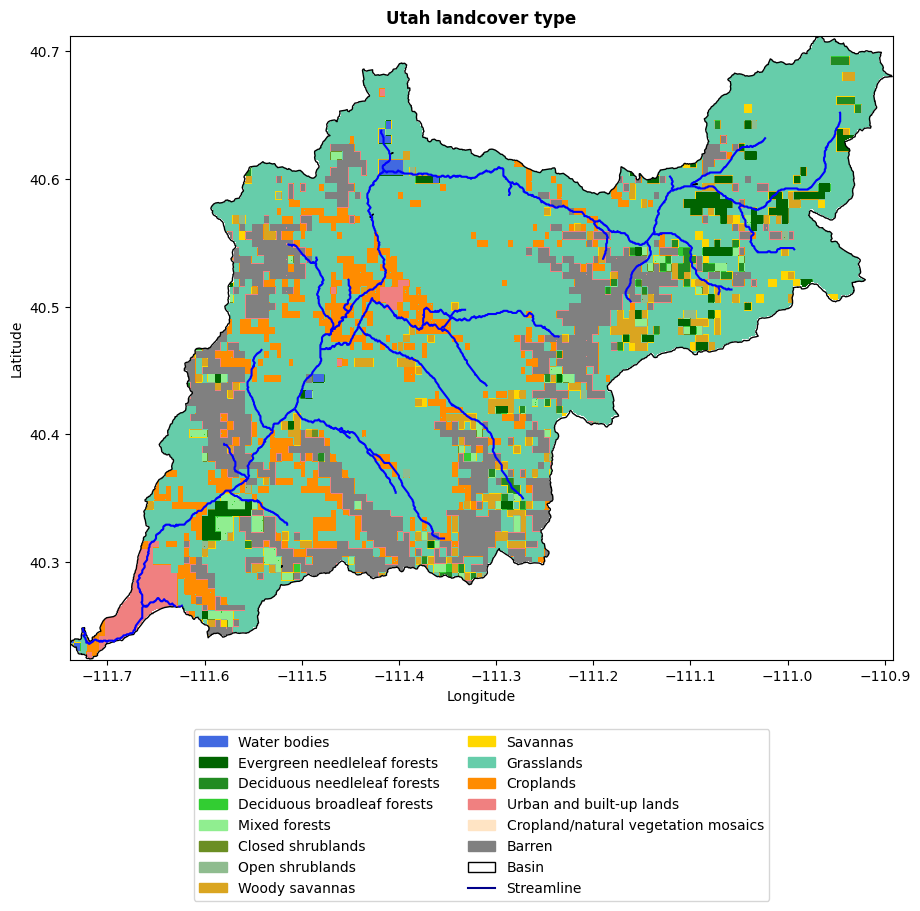

In [14]:
# plot settings
wgs_epsg  = 4326
figsize   = (15, 15*0.6) # width, height in inches
title     = basin_name.capitalize() + ' landcover type'
leg_ncol  = 2
leg_loc   = 'upper center'
leg_bbox_to_anchor = (0.5,-0.1)
  
# IGBP classifications
legend_dict={0:["royalblue", 'Water bodies'],
             1:["darkgreen", "Evergreen needleleaf forests"],
             2:["green", "Evergreen broadleaf forests"],
             3:["forestgreen", 'Deciduous needleleaf forests'],
             4:["limegreen", 'Deciduous broadleaf forests'], 
             5:["lightgreen", 'Mixed forests'], 
             6:["olivedrab", 'Closed shrublands'], 
             7:["darkseagreen", 'Open shrublands'], 
             8:["goldenrod", 'Woody savannas'], 
             9:["gold", 'Savannas'], 
             10:["mediumaquamarine", 'Grasslands'], 
             11:["powderblue", 'Permanent wetlands'], 
             12:["darkorange", 'Croplands'], 
             13:["lightcoral", 'Urban and built-up lands'], 
             14:["bisque", 'Cropland/natural vegetation mosaics'], 
             15:["snow", 'Snow and ice'], 
             16:["grey", 'Barren']} 

# set plot name and color choice
output_fig_file = os.path.join(plot_path, 'landcover_and_bound_stream.png')   
cmap_str='user'

# plot land cover classes
# (something is wrong with the categories shown in the plot but the categories appear to be ok from the data)
gp.plot_raster_and_bound_stream(basin_landcover_raster, basin_gru_prj_shp, basin_flowlines_shp, wgs_epsg, cmap_str,
                                legend_dict, figsize,title, leg_loc, leg_bbox_to_anchor, leg_ncol, output_fig_file)

#### 6. Visualize basin landcover canopy/no-canopy classification ####

data_unique: [1 2]
data_counts: [ 13973 253800]
length data_unique: 2
legend_labels: {np.int32(1): ['black', 'Canopy'], np.int32(2): ['whitesmoke', 'Non-canopy']}


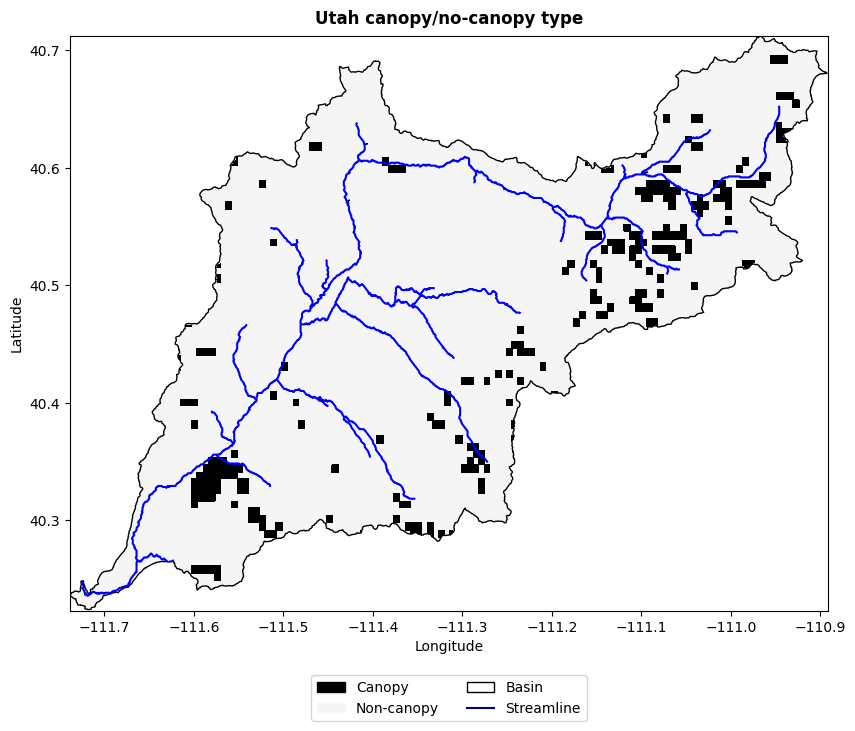

In [15]:
# plot settings
wgs_epsg    = 4326
figsize     = (12, 12*0.6) # width, height in inches
title       = basin_name.capitalize() + ' canopy/no-canopy type'
leg_ncol    = 2
leg_loc     = 'upper center'
leg_bbox_to_anchor = (0.5,-0.1)
legend_dict = {1:["black", "Canopy"],
               2:["whitesmoke", "Non-canopy"]} 

# set plot name and color choice
output_fig_file = os.path.join(plot_path, 'canopy_class_and_bound_stream.png')   
cmap_str = 'user'

# plot canopy vs no-canopy decision
gp.plot_raster_and_bound_stream(basin_canopy_class_raster, basin_gru_prj_shp, basin_flowlines_shp,
                                wgs_epsg, cmap_str, legend_dict, figsize, title, leg_loc, leg_bbox_to_anchor, leg_ncol, output_fig_file)
